In [3]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler

from pylab import meshgrid

from sklearn.cluster import KMeans


import itertools

pd.options.display.max_columns = None

from sklearn.cluster import DBSCAN
from sklearn import metrics

In [4]:
adni_df = pd.read_csv("data/ADNIMERGE.csv", low_memory=False)

# Investigating Baseline Data with Clustering

Before constructing our longitudinal model, we decided to get a sense of the whether the data naturally clustered into three categories of cognitively normal, mild cognitive impairment and dementia. To do this, we used SKlearn's DBSCAN feature, which automatically clusters data into a certain number of groups based on the input parameters epsilon (the maximum distance between two samples for them to be considered as in the same neighborhood) and min_samples (the number of samples in a group for a point to be considered as a core point, including the point itself)

In [17]:
cols = ['mPACCdigit','RAVLT_immediate','DX']
# cols = ['ABETA','MMSE','DX']
df = adni_df[cols][adni_df['M']==0]
df.loc[:,'DX'] = adni_df['DX_bl'].map({'CN': 1, 'AD': 0, 'LMCI': 0, 'SMC': 0, 'EMCI': 0, 'NONE': 0})
df = df.dropna()

In [18]:
X = df[['mPACCdigit','RAVLT_immediate']]
# X = X.replace('>1700',1700)
# X = X.replace('<200',200)
X = StandardScaler().fit_transform(X)
labels_true = df['DX']
X

array([[ 0.16916018,  0.57656579],
       [-1.78509267, -1.1365636 ],
       [-0.49273528,  0.03147917],
       ...,
       [-0.15769333, -0.74721601],
       [ 0.96418547,  1.58886953],
       [ 0.74339089,  0.73230483]])

In [19]:
db = DBSCAN(eps=0.25, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 1
Estimated number of noise points: 45
Homogeneity: 0.001
Completeness: 0.005
V-measure: 0.002
Adjusted Rand Index: -0.010
Adjusted Mutual Information: 0.001
Silhouette Coefficient: 0.332


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


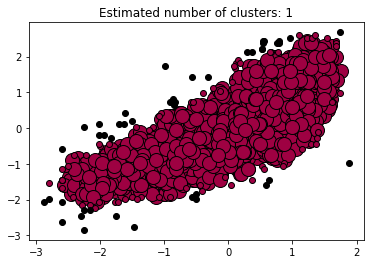

In [20]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    xy = np.array(xy)
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    xy = np.array(xy)
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

This suggests that these two predictors, which in EDA appeared to be amongst the best for splitting the response variable categories in truth do not create distinct clusters. To confirm this, we re-ran the dbscan algorithm across a range of input parameters and examined the output to see whether the results were parameter-dependent.

In [21]:
def dbscanner(X, ep, ms):
    try:
        db = DBSCAN(eps=ep, min_samples=ms).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        return n_clusters_, n_noise_ 
    except ValueError:      
        n_clusters = 0
        n_noise = len(X)
        return n_clusters_, n_noise_


In [22]:
ep_range = np.linspace(0.05,0.5,10)
ms_range = np.linspace(100,1000,10)

Z1 = np.zeros((10,10))
Z2 = np.zeros((10,10))

for i, ep in enumerate(ep_range):
    for j, ms in enumerate(ms_range):
        z = dbscanner(X,ep,ms)
        Z1[i,j] = z[0]
        Z2[i,j] = z[1]

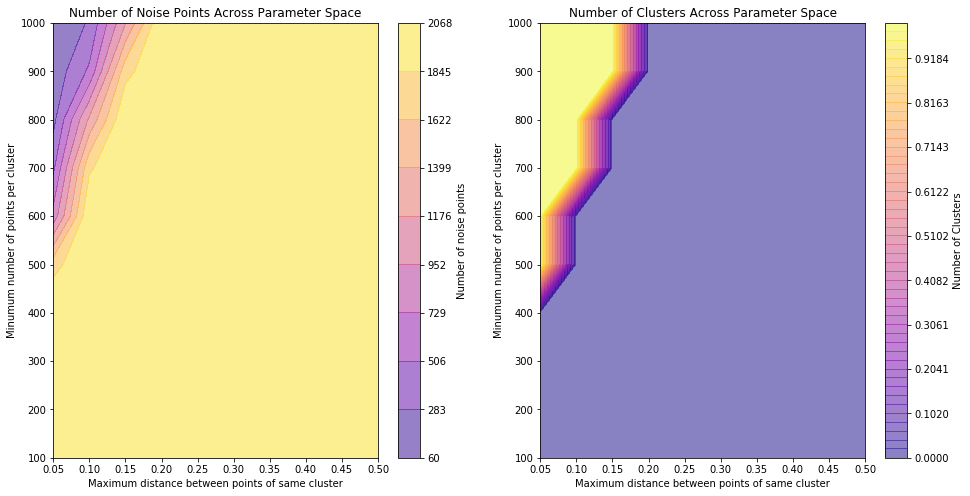

In [24]:
xx, yy = meshgrid(ep_range,ms_range)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
L = np.linspace(np.min(Z2),np.max(Z2),10)
c1 = ax.contourf(xx,yy,Z2,L, cmap='plasma', alpha = 0.5)
cbar = plt.colorbar(c1)
cbar.ax.set_ylabel('Number of noise points')
plt.xlabel("Maximum distance between points of same cluster")
plt.ylabel("Minumum number of points per cluster")
plt.title("Number of Noise Points Across Parameter Space")
ax = fig.add_subplot(122)
L = np.linspace(np.min(Z1),np.max(Z1),50)
c1 = ax.contourf(xx,yy,Z1,L, cmap='plasma', alpha = 0.5)
cbar = plt.colorbar(c1)
cbar.ax.set_ylabel('Number of Clusters')
plt.xlabel("Maximum distance between points of same cluster")
plt.ylabel("Minumum number of points per cluster")
plt.title("Number of Clusters Across Parameter Space")
plt.show()

These plots show that for a large range of the chosen sample space, clustering cannot be performed properly (no clusters identified and all points assigned as noise) and when clustering is achieved, it does not predict more than one cluster being present for any parameter input - again confirming that, for these predictors, the data does not segregate well. 

To further explore, we carried out K-means clustering and enforced three clusters, to see whether the chosen clustered groups look similar to the true group distributions.

In [95]:
cols = ['mPACCdigit','RAVLT_immediate','DX']
df = adni_df[cols][adni_df['M']==0]
df = df.dropna()
X = df[['mPACCdigit','RAVLT_immediate']]
X = StandardScaler().fit_transform(X)
labels_true = df['DX']
y0 = labels_true.map({"CN":1,"MCI":2,"Dementia":3})
CMAlogreg = LogisticRegression(solver='lbfgs', multi_class='ovr').fit(X,y0)
CMAlogreg.score(X,y0)

0.7690441533236293

In [97]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [34]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier (has a `.predict` method)
    X: feature vectors
    y: ground-truth classes
    colors: list of colors to use. Use color colors[i] for class i.
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    """
    # Create mesh
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points
    if hasattr(model, 'predict'):
        model = model.predict
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        colors = sns.utils.get_color_cycle()
        y -= y.min() # If first class is not 0, shift.
    assert np.max(y) <= len(colors)
    colors = [sns.utils.desaturate(color, desaturate) for color in colors]
    cmap = matplotlib.colors.ListedColormap(colors)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1, alpha=0.1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
#     ax.contourf(xx, yy, y, cmap=cmap, vmin=0, vmax=3)
    ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)

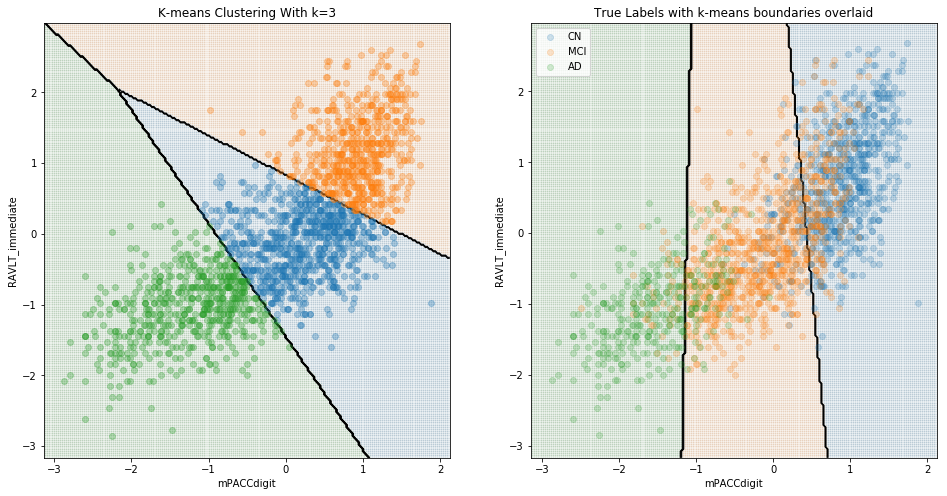

In [99]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
XP0 = X[kmeans.labels_==0]
XP1 = X[kmeans.labels_==1]
XP2 = X[kmeans.labels_==2]
ax.scatter(XP0[:,0],XP0[:,1],alpha=0.3)
ax.scatter(XP1[:,0],XP1[:,1],alpha=0.3)
ax.scatter(XP2[:,0],XP2[:,1],alpha=0.3)
overlay_decision_boundary(ax, kmeans)
plt.xlabel('mPACCdigit')
plt.ylabel('RAVLT_immediate')
plt.title("K-means Clustering With k=3")

ax = fig.add_subplot(122)
plt.title("True Labels with k-means boundaries overlaid")
XTC = X[labels_true=='CN']
XTM = X[labels_true=='MCI']
XTA = X[labels_true=='Dementia']
ax.scatter(XTC[:,0],XTC[:,1], label="CN",alpha=0.2)
ax.scatter(XTM[:,0],XTM[:,1], label="MCI",alpha=0.2)
ax.scatter(XTA[:,0],XTA[:,1], label="AD",alpha=0.2)




overlay_decision_boundary(ax, CMAlogreg)
plt.xlabel('mPACCdigit')
plt.ylabel('RAVLT_immediate')
plt.legend()
plt.show()

Here, we can see that although the boundaries predicted by this clustering algorithm capture aspects of the different distributions of the groups, it is certainly true that the groups do not clearly cluster, and the unlabeled clustering category boundaries are substantially different to the boundaries determined by logistic regression of labelled data. When considering just cognitively normal and Alzheimer's disease, clustering is far more successful:

In [77]:
cols = ['mPACCdigit','RAVLT_immediate','DX']
df = adni_df[cols][adni_df['M']==0]
df = df.dropna()
LT = df['DX']
df2 = df[LT!='MCI']
X2 = df2[['mPACCdigit','RAVLT_immediate']]
X2 = StandardScaler().fit_transform(X2)
labels_true = df2['DX']

In [87]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X2)
ylr = labels_true.map({'CN':0,'Dementia':1})
CNADlogreg = LogisticRegression(solver='lbfgs').fit(X2,ylr)
CNADlogreg.score(X2,ylr)

0.9911347517730497

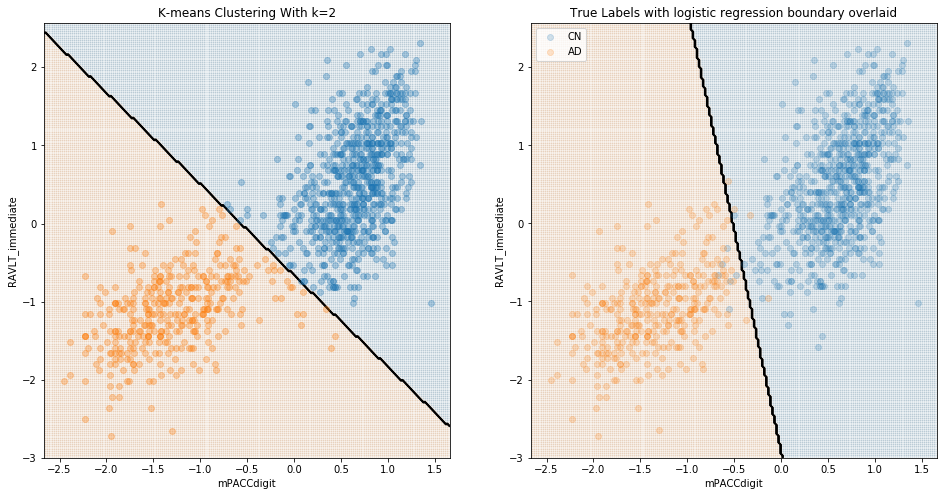

In [88]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
XP0 = X2[kmeans.labels_==0]
XP1 = X2[kmeans.labels_==1]
ax.scatter(XP0[:,0],XP0[:,1],alpha=0.3)
ax.scatter(XP1[:,0],XP1[:,1],alpha=0.3)
overlay_decision_boundary(ax, kmeans)
plt.xlabel('mPACCdigit')
plt.ylabel('RAVLT_immediate')
plt.title("K-means Clustering With k=2")

ax = fig.add_subplot(122)
plt.title("True Labels with logistic regression boundary overlaid")
XTC = X2[labels_true=='CN']
XTA = X2[labels_true=='Dementia']
ax.scatter(XTC[:,0],XTC[:,1], label="CN",alpha=0.2)
ax.scatter(XTA[:,0],XTA[:,1], label="AD",alpha=0.2)
overlay_decision_boundary(ax, CNADlogreg)
plt.xlabel('mPACCdigit')
plt.ylabel('RAVLT_immediate')
plt.legend()
plt.show()

This is to be expected. When considering MCI, however, we see it is bad at separating from either CN or Dementia.

0.8889751552795031


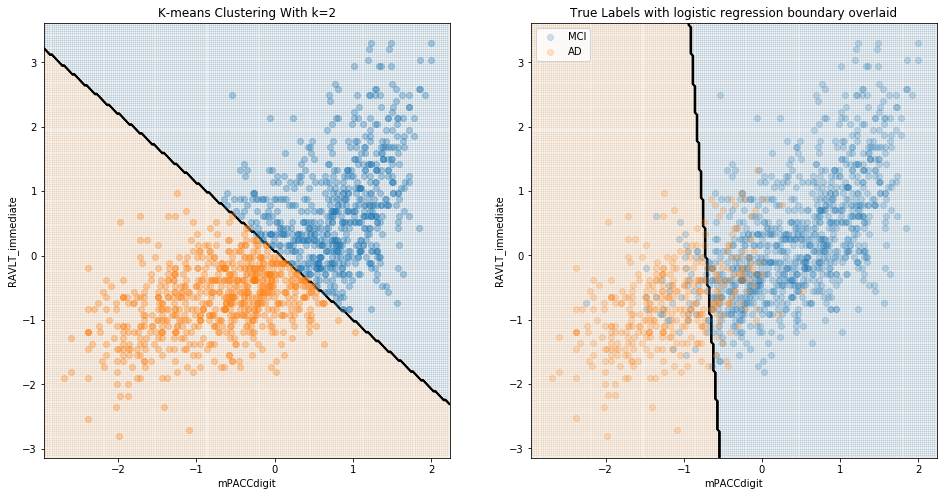

In [103]:
cols = ['mPACCdigit','RAVLT_immediate','DX']
df = adni_df[cols][adni_df['M']==0]
df = df.dropna()
LT = df['DX']
df2 = df[LT!='CN']
X2 = df2[['mPACCdigit','RAVLT_immediate']]
X2 = StandardScaler().fit_transform(X2)
labels_true = df2['DX']
kmeans = KMeans(n_clusters=2, random_state=0).fit(X2)
ylr = labels_true.map({'MCI':0,'Dementia':1})
CNADlogreg = LogisticRegression(solver='lbfgs').fit(X2,ylr)
print(CNADlogreg.score(X2,ylr))
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
XP0 = X2[kmeans.labels_==0]
XP1 = X2[kmeans.labels_==1]
ax.scatter(XP0[:,0],XP0[:,1],alpha=0.3)
ax.scatter(XP1[:,0],XP1[:,1],alpha=0.3)
overlay_decision_boundary(ax, kmeans)
plt.xlabel('mPACCdigit')
plt.ylabel('RAVLT_immediate')
plt.title("K-means Clustering With k=2")

ax = fig.add_subplot(122)
plt.title("True Labels with logistic regression boundary overlaid")
XTM = X2[labels_true=='MCI']
XTA = X2[labels_true=='Dementia']
ax.scatter(XTM[:,0],XTC[:,1], label="MCI",alpha=0.2)
ax.scatter(XTA[:,0],XTA[:,1], label="AD",alpha=0.2)
overlay_decision_boundary(ax, CNADlogreg)
plt.xlabel('mPACCdigit')
plt.ylabel('RAVLT_immediate')
plt.legend()
plt.show()

Now comparing MCI and CN:

0.8130128956623681


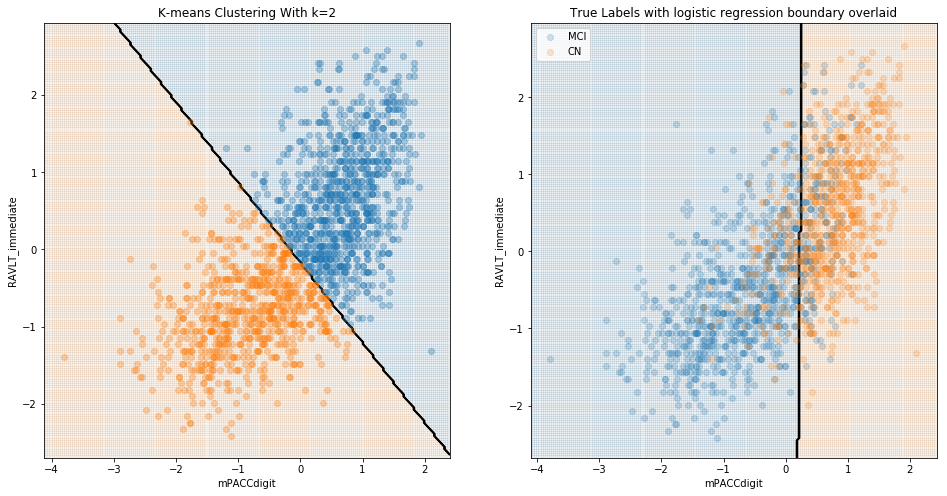

In [106]:
cols = ['mPACCdigit','RAVLT_immediate','DX']
df = adni_df[cols][adni_df['M']==0]
df = df.dropna()
LT = df['DX']
df2 = df[LT!='Dementia']
X2 = df2[['mPACCdigit','RAVLT_immediate']]
X2 = StandardScaler().fit_transform(X2)
labels_true = df2['DX']
kmeans = KMeans(n_clusters=2, random_state=0).fit(X2)
ylr = labels_true.map({'MCI':0,'CN':1})
CNADlogreg = LogisticRegression(solver='lbfgs').fit(X2,ylr)
print(CNADlogreg.score(X2,ylr))
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
XP0 = X2[kmeans.labels_==0]
XP1 = X2[kmeans.labels_==1]
ax.scatter(XP0[:,0],XP0[:,1],alpha=0.3)
ax.scatter(XP1[:,0],XP1[:,1],alpha=0.3)
overlay_decision_boundary(ax, kmeans)
plt.xlabel('mPACCdigit')
plt.ylabel('RAVLT_immediate')
plt.title("K-means Clustering With k=2")

ax = fig.add_subplot(122)
plt.title("True Labels with logistic regression boundary overlaid")
XTM = X2[labels_true=='MCI']
XTC = X2[labels_true=='CN']
ax.scatter(XTM[:,0],XTM[:,1], label="MCI",alpha=0.2)
ax.scatter(XTC[:,0],XTC[:,1], label="CN",alpha=0.2)
overlay_decision_boundary(ax, CNADlogreg)
plt.xlabel('mPACCdigit')
plt.ylabel('RAVLT_immediate')
plt.legend()
plt.show()

Stuff to do:

Try different predictors, find quantitive measure of heterogeneity/separation of the data.